In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

### Secion 2 Crouseilles Lawson for Dahlquist eq.

$$u_t = \lambda_1u + \lambda_2u \equiv Au + F(u)$$
$$|\lambda_1| >> |\lambda_2|$$

var. change: $$v = e^{-tA}u(t) \equiv e^{-t\lambda_1}u(t) $$

$$v_t = e^{-tA}F(e^{tA}v(t)) \equiv \lambda_2 v(t) = f(v)$$

In [2]:
l1, l2 = -10 + 0.j, -0.03j
t0 = 0.0
u0 = 1.0 + 0.j
steps = 101 # t=0. -> t=1.

t = np.empty((steps))
timestep = 0.01

u = np.empty((steps), dtype=np.cfloat)
uv = np.empty((steps), dtype=np.cfloat)

# var change
v0 = u0 * np.exp(-t0*l1) # === 1.0

# rhs for v
def fv(t, v):
    return l2 * v

# rhs for u
def fu(t, u):
    return (l1 + l2) * u

In [3]:
# plotting function
def plot_solutions(plot_name, method_names, method_solutions, shared_t):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    global l1, l2
    fig.suptitle('%s: Dahlquist w/ modes l1=%.2f %+.2fi; l2=%.2f %+.2fi' % (plot_name, l1.real, l1.imag, l2.real, l2.imag), fontsize=10)
    fig.set_size_inches((10,4))

    for name, solution in zip(method_names, method_solutions):
        ax1.plot(shared_t, solution.real, label=name)
        ax2.plot(shared_t, solution.imag, label=name)
    
    ax1.legend()
    ax1.set_xlabel("t")
    ax1.set_ylabel("Re(u(t))")

    ax2.legend()
    ax2.set_xlabel("t")
    ax2.set_ylabel("Im(u(t))")
    plt.show()
    
    return

### Lawson-RK45 and direct RK45

max error Lawson-RK 1.1102251422055052e-16
max error RK 1.2090641662340153e-09


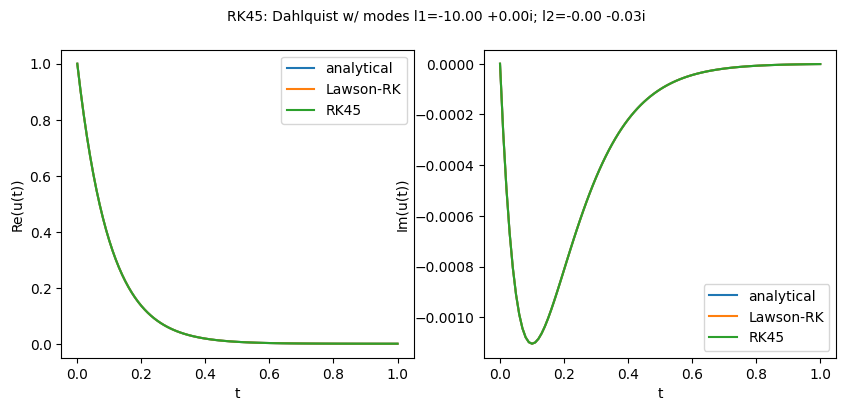

In [4]:
# RK45(u) and Lawson-RK45(v) integrators
v_integ = scipy.integrate.RK45(fv, t0, [v0], 100., first_step=timestep, max_step=timestep)
u_integ = scipy.integrate.RK45(fu, t0, [u0], 100., first_step=timestep, max_step=timestep)

for i in range(steps):
    t[i] = v_integ.t
    uv[i] = v_integ.y * (np.exp(v_integ.t*l1) + 0.j)
    v_integ.step()
    u[i] = u_integ.y
    u_integ.step()

print("max error Lawson-RK", np.max(np.abs(uv - np.exp((l1 + l2)*t))))
print("max error RK", np.max(np.abs(u - np.exp((l1 + l2)*t))))

plot_solutions("RK45", ["analytical", "Lawson-RK", "RK45"], [np.exp((l1 + l2)*t), uv, u], t)

### Lawson Euler-SDC (Buvoli 2.2)

sweep amount 3 max error 2.2204502844110104e-16
Lawson vars error 7.772045176131504e-16


/opt/homebrew/lib/python3.10/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


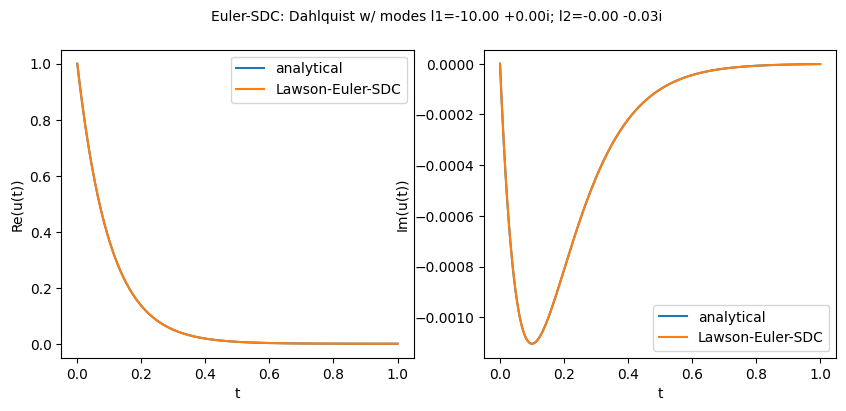

In [5]:
N = 5
Ti = (N+1) * (steps-1) + 1
taui, _ = np.polynomial.chebyshev.chebgauss(N)

tau = np.empty((Ti))
for i in range(steps-1):
    tau[(N+1)*i] = t[i]
    tau[(N+1)*i+1:(N+1)*i+(N+1)] = taui[::-1] / 2 * timestep + timestep / 2 + t[i]
tau[-1] = 1.

# u -> v change variables and propagate solution
uv_sdc = np.empty((Ti), dtype=np.cfloat)
uv_sdc[0] = u0 # * np.exp(-t0*l1) === 1.0
dtau = tau[1:] - tau[:-1]

# v -> u change of variables
exptl1 = np.exp(tau * l1) + 0.j

M = 3

# init chebychev series
Order = N+2
nodetonode = np.zeros((N+1))

for j in range(steps-1): # timesteps
    left = j*(N+1)
    right = (j+1)*(N+1)+1
    
    # propagate initial solution
    for i in range(left+1,right):
        uv_sdc[i] = uv_sdc[i-1] + dtau[i-1] * fv(tau[i-1], uv_sdc[i-1])
    
    tau_slice = tau[left:right]
    dtau_slice = dtau[0:N+1]
    integr = np.zeros((Order))
    series = np.polynomial.chebyshev.Chebyshev(np.zeros((Order)), \
             domain=[tau_slice[0], tau_slice[-1]], window=[tau_slice[0], tau_slice[-1]])
    
    for k in range(M): # sweeps
        uv_sdc_slice = np.copy(uv_sdc[left:right]) # save φk
        # fit a series
        series = series.fit(tau_slice, fv(tau_slice, uv_sdc_slice), deg=Order)
        # integrate
        integseries = series.integ(m=1, lbnd=tau_slice[0])
        zerotonode = integseries(tau_slice)
        nodetonode = zerotonode[1:] - zerotonode[:-1]
        
        Ek = 0.
        for i in range(N+1): # time substeps
            # φk+1i+1 =φk+1i +hiF(hτi+l,φk+1)−F(hτi+l,φk)+Ii+1(φk)
            uv_sdc[left+i+1] = uv_sdc[left+i] + dtau_slice[i] * \
                               (fv(tau_slice[i], uv_sdc[left+i]) - \
                                fv(tau_slice[i], uv_sdc_slice[i])) + nodetonode[i]
    
# calculate total error
print("sweep amount", M, "max error", np.max(np.abs(uv_sdc * exptl1 - np.exp((l1 + l2)*tau))))
print("Lawson vars error", np.max(np.abs(uv_sdc - np.exp(l2*tau))))

# plot solution
plot_solutions("Euler-SDC", ["analytical", "Lawson-Euler-SDC"], [np.exp((l1 + l2)*tau), (uv_sdc * exptl1)], tau)

In [6]:
# explicit Euler equidistant nodes
for i in range(1, steps): 
    uv_sdc[i*(N+1)] = uv_sdc[(i-1)*(N+1)] + timestep * fv(t[i-1], uv_sdc[(i-1)*(N+1)])

print("max error Lawson-Euler", np.max(np.abs(uv_sdc[::N+1] * exptl1[::N+1] - np.exp((l1 + l2)*t))))

max error Lawson-Euler 1.6554578165218458e-07


### ETD-SDC (Buvoli 2.3)

$$u_t = \lambda_1u + \lambda_2u \equiv \Lambda u + N(u)$$
$$|\lambda_1| >> |\lambda_2|$$

$$\Lambda = \lambda_1; N(\cdot) = \lambda_2*$$

In [7]:
from fd_weights_explicit import get_fd_stencil

In [8]:
def generate_weights(tau_stencil):
    M = np.shape(tau_stencil)
    W = np.empty((M, M))
    
    # ...
    
    
    return W

sweep amount 3 max error 4.2076182976282483e-05


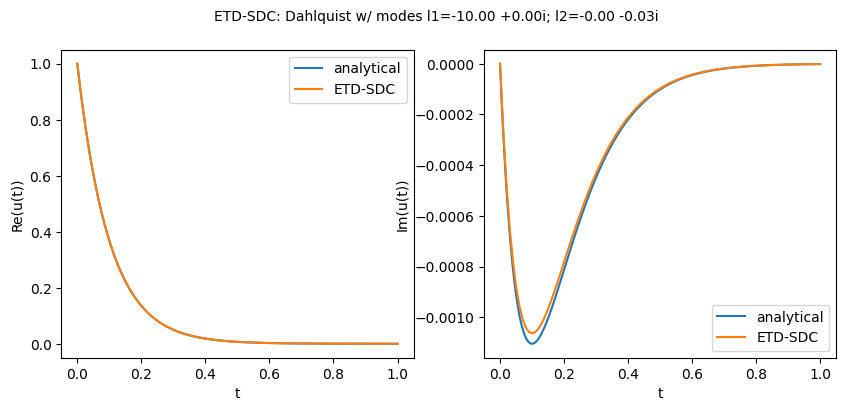

In [9]:
# NOTE: rhs integration is missing proper integration...

M = 3

u_sdc = np.copy(uv_sdc)
u_sdc[0] = u0

# init chebychev series
Order = N+2
nodetonode = np.zeros((N+1))

for j in range(steps-1): # timesteps
    left = j*(N+1)
    right = (j+1)*(N+1)+1
    
    # propagate initial solution
    for i in range(left+1,right):
        u_sdc[i] = u_sdc[i-1] * np.exp(l1 * dtau[i-1]) + \
                    1 / l1 * (np.exp(dtau[i-1] * l1) - 1) * l2 * u_sdc[i-1]
    
    tau_slice = tau[left:right]
    dtau_slice = dtau[0:N+1]
    integr = np.zeros((Order))
    series = np.polynomial.chebyshev.Chebyshev(np.zeros((Order)), \
             domain=[tau_slice[0], tau_slice[-1]], window=[tau_slice[0], tau_slice[-1]])
    
    for k in range(M): # sweeps
        
        # NOTE: we do not create a series and then integrate it here, instead 
        #       a weighted sum must be calculated directly, where weights don't
        #       really depend on N(), rather on time grid -> the whole point of ETD
        
        # but maybe for now I can use interpolation? 

        u_sdc_slice = np.copy(u_sdc[left:right]) # save φk
        series = series.fit(tau_slice, np.exp(l1 * (tau_slice[-1] - tau_slice)) * l2 * u_sdc_slice, deg=Order)
        
        integseries = series.integ(m=1, lbnd=tau_slice[0])
        zerotonode = integseries(tau_slice)
        nodetonode = zerotonode[1:] - zerotonode[:-1]
        
        Ek = 0.
        for i in range(N+1): # time substeps
            # φk+1i+1 =φk+1i ehiΛ + Λ^−1 [ehiΛ−1] (N(hτi,φk+1i) − N(hτi,φki))+Wi;i+1(φk)
            u_sdc[left+i+1] = u_sdc[left+i]*np.exp(dtau_slice[i]*l1) + 1 / l1 * \
                                (np.exp(dtau_slice[i]*l1)-1) * dtau_slice[i] * \
                                (l2 * u_sdc[left+i] - l2 * u_sdc_slice[i]) + nodetonode[i]
    
# calculate total error
print("sweep amount", M, "max error", np.max(np.abs(u_sdc - np.exp((l1 + l2)*tau))))
# plot solution
plot_solutions("ETD-SDC", ["analytical", "ETD-SDC"], [np.exp((l1 + l2)*tau), u_sdc], tau)

In [10]:
u_sdc = np.copy(uv_sdc)
u_sdc[0] = u0

# propagate initial solution
for i in range(1, Ti):
    u_sdc[i] = u_sdc[i-1] * np.exp(l1 * dtau[i-1]) + \
                1 / l1 * (np.exp(dtau[i-1] * l1) - 1) * l2 * u_sdc[i-1]
            
print("ETD Euler error", np.max(np.abs(u_sdc - np.exp((l1 + l2)*tau))))

ETD Euler error 1.3443717632367695e-05


### IMEX-SDC (Buvoli 2.4)

sweep amount 7 max error 6.511476523676472e-08


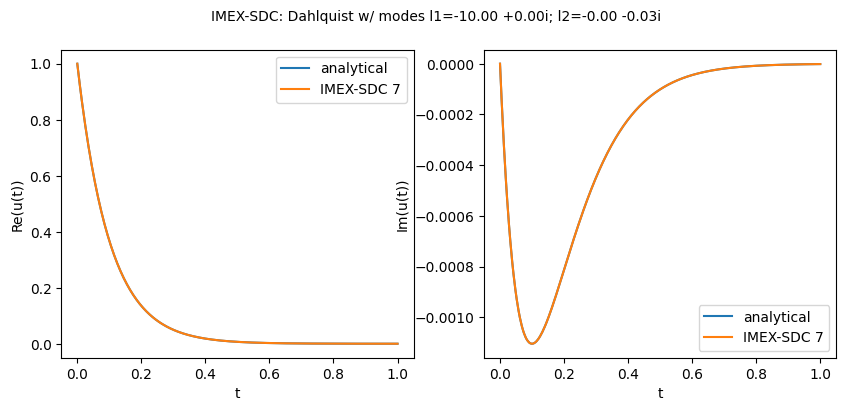

In [11]:
M = 7

u_sdc = np.copy(uv_sdc)
u_sdc[0] = u0

# init chebychev series
Order = N+2
nodetonode = np.zeros((N+1))

for j in range(steps-1): # timesteps
    left = j*(N+1)
    right = (j+1)*(N+1)+1
    
    # propagate initial solution
    for i in range(left+1,right):
        u_sdc[i] = 1/(1 - dtau[i-1]*l1) * (u_sdc[i-1] + dtau[i-1] * l2 * u_sdc[i-1])
    
    tau_slice = tau[left:right]
    dtau_slice = dtau[0:N+1]
    integr = np.zeros((Order))
    series = np.polynomial.chebyshev.Chebyshev(np.zeros((Order)), \
             domain=[tau_slice[0], tau_slice[-1]], window=[tau_slice[0], tau_slice[-1]])
    
    for k in range(M): # sweeps
        # Interpolate Λφk (s) + N (s, φk (s))ds.
        u_sdc_slice = np.copy(u_sdc[left:right]) # save φk
        series = series.fit(tau_slice, (l1 + l2) * u_sdc_slice, deg=Order)
        
        integseries = series.integ(m=1, lbnd=tau_slice[0])
        zerotonode = integseries(tau_slice)
        nodetonode = zerotonode[1:] - zerotonode[:-1]
        
        Ek = 0.
        for i in range(N+1): # time substeps
            # φk+1i+1 =[I−hiΛ]^-1 ...
            u_sdc[left+i+1] = 1 / (1 - dtau_slice[i] * l1) * \
                                (u_sdc[left+i] - (dtau_slice[i] * l1) * u_sdc_slice[i+1] + \
                                 dtau_slice[i] * l2 * (u_sdc[left+i] - u_sdc_slice[i]) + \
                                 nodetonode[i])

print("sweep amount", M, "max error", np.max(np.abs(u_sdc - np.exp((l1 + l2)*tau))))
# plot solution
plot_solutions("IMEX-SDC", ["analytical", "IMEX-SDC " + str(M)], [np.exp((l1 + l2)*tau), u_sdc], tau)